# Signals versus variables

A signal can be seen as a wire in a circuit. When something happens, like a state change from `low` to `high`, a circuit element might be triggered by it. Or, it could be sampled at a specific rising edge of another trigger or clock signal.

We remember: A signal is **always** set using the `.next` attribute assignment statement.

**Question:** Why does that make sense in Python?

Variables, on the other hand, take their assignment immediately. What's on the left hand side is set to what's on the right hand side. The previous value *and type* of the Python variable is then obviously gone. This is something that is restricted in particular for MyHDL synthesis: Variables, once assigned, must hold the same type upon reassignment.

Let us visit a few examples.

### Simple conditional assignment

Note:

* Variables are normally not shared between processes, unless they are static constants
* Variables inside a process must be initialized once outside a conditional statement. This acts like a
  declaration
* When re-assigning the variable to another value, the right hand side must have the same type as the
  first assignment


In [1]:
from myhdl import *
from frequently_used import up_counter

@block
def simple_variable(clk, ce, reset, dout, debug):
    "Simple variable example"
    counter = Signal(modbv(0)[8:])
    cr = ResetSignal(0, 1, isasync = False)
    ctr = up_counter(clk, 1, cr, counter)

    @always_seq(clk.posedge, reset)
    def fsm():        
        v = intbv(0xff)[8:] # default value

        if ce:
            v = intbv(0xaa)[8:]
    
        dout.next = v
    @always_comb
    def assign():
        debug.next = 0
        cr.next = reset

    return instances()


Synthesize (we import the regular code from the `std_ex` module)

In [2]:
from std_ex import standard_conversion
ARST = True
design = standard_conversion(simple_variable, ARST)

CREATE Module: 'up_counter_0'
Adding module with name: up_counter_1_c1_1_8
CONVERT_RTL tree >>>>>> 'SIMPLE_VARIABLE_UP_COUNTER_0_WORKER' 
TRUNC: /home/pyosys/src/myhdl/myhdl-local/example/ipynb/work/myhdl-synthesis/examples/frequently_used.py:17 Implicit carry truncate: counter[8:], src[9:]
DONE instancing submodules
CREATE Module: 'simple_variable'
Adding module with name: simple_variable_1_1_1_8_8
CONVERT_RTL tree >>>>>> 'SIMPLE_VARIABLE_FSM' 
CONVERT_RTL tree >>>>>> 'SIMPLE_VARIABLE_ASSIGN' 
++++++++ up_counter_0: up_counter_1_c1_1_8 (Module) ++++++++
DONE instancing submodules


Display top level module:

Generating RTL image...
Display...


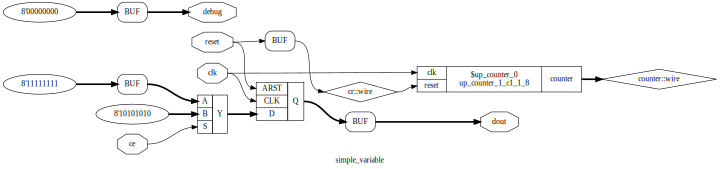

In [3]:
from ys_aux import to_svg
display(to_svg(design, "\\simple_variable", 100))

## Test bench

In [4]:
from frequently_used import clkgen, lfsr8


@block
def tb_fsm(which, clk, ce, reset, dout, debug):
    osc = clkgen(clk, 1)
    o = Signal(intbv()[8:])    
    inst_fsm = which(clk, ce, reset, dout, debug)

    @always_comb
    def assign():
        ce.next = o[0]
        
    @instance
    def stim():
        ce.next = False
        reset.next = True
        yield delay(4)
        reset.next = False
        
        for v in [1, 1, 1, 1, 0, 0, 1, 0, 1]:
            ce.next = v
            yield clk.posedge
            
        raise StopSimulation
        
        
    return instances()
        


## Post-Synthesis simulation

We directly run the post-synthesis simulation and display the result:

In [5]:
import nbwavedrom
from std_ex import standard_trace

def U(x):
    return ".dut." + x

# Configure waveform:
cfg = { U('reset') : None, U('dout[7:0]') : None, U('debug') : None}
cfg[U('ce')] = None

# Pass `None` as last parameter to display all signals
waveform = standard_trace("simple_variable", ".dut.clk", tb_fsm, ARST, cfg)

nbwavedrom.draw(waveform)

<class 'myhdl._SuspendSimulation'>: Simulated 20 timesteps


## Signal variant

In [6]:
from myhdl import *
from frequently_used import up_counter

@block
def simple_signal(clk, ce, reset, dout, debug):
    "Complex FSM test case with explicit state assignment coverage"
    counter = Signal(modbv(0)[8:])
    cr = ResetSignal(0, 1, isasync = False)
    ctr = up_counter(clk, 1, cr, counter)
    v = Signal(intbv(0xff)[8:])

    @always_seq(clk.posedge, reset)
    def fsm():        
        v.next = 0xff

        if ce:
            v.next = 0xaa
    
        dout.next = v
        
    @always_comb
    def assign():
        debug.next = 0
        cr.next = reset

    return instances()


We use the same reset signal, but convert the `simple_signal` unit instead:

In [7]:
design = standard_conversion(simple_signal, ARST)

CREATE Module: 'up_counter_0_0'
Adding module with name: up_counter_1_c1_1_8
CONVERT_RTL tree >>>>>> 'SIMPLE_SIGNAL_UP_COUNTER_0_0_WORKER' 
TRUNC: /home/pyosys/src/myhdl/myhdl-local/example/ipynb/work/myhdl-synthesis/examples/frequently_used.py:17 Implicit carry truncate: counter[8:], src[9:]
DONE instancing submodules
CREATE Module: 'simple_signal'
Adding module with name: simple_signal_1_1_1_8_8
CONVERT_RTL tree >>>>>> 'SIMPLE_SIGNAL_FSM' 
CONVERT_RTL tree >>>>>> 'SIMPLE_SIGNAL_ASSIGN' 
++++++++ up_counter_0_0: up_counter_1_c1_1_8 (Module) ++++++++
DONE instancing submodules


### Display Waveform of 'signal' variant

In [8]:
waveform = standard_trace("simple_signal", ".dut.clk", tb_fsm, ARST, cfg)
nbwavedrom.draw(waveform)

<class 'myhdl._SuspendSimulation'>: Simulated 20 timesteps


### Compare against 'variable' variant

In [9]:
waveform = standard_trace("simple_variable", ".dut.clk", tb_fsm, ARST, cfg)
nbwavedrom.draw(waveform)

<class 'myhdl._SuspendSimulation'>: Simulated 20 timesteps


## Exercises

1. Why is there a `0xff` in the above `tb_simple_signal.dut.dout[7:0]` signal, why is it not in `tb_simple_variable.dut.dout[7:0]`?

**FILL IN HERE**